
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2025<br>
<font color=3C99D size=5>
    Project-Phase1<br>
    Image Segmentation<br>
<font color=696880 size=4>
    Shayan Baghayi Nejad-Armin Khosravi


<font size=5 color=cyan> Names:</font>
Zeinab Ashouri, Sogol Zamanian

<font size=5 color=cyan>Student Numbers:  </font>
401103882, 401109014

# Introduction

In this Project, we will become familiar with UNet architecture, Attention mechanism, and Residual blocks with the help of which we will build UNet, AttentionUNet, and ResidualAttentionUnet from scratch using PyTorch framework. The built models will be evaluated by various metrics such as accuracy, Iou score, and Dice score.

### Environment Setup

Here you will find the required packages. Feel free to add the list.

In [52]:
import os
import shutil
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import kagglehub
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import Adam
from tqdm import tqdm
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Hyperparameter Setting

Place your hyperparameters' values in the cell below.

In [53]:
DATA_DIR = None
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 4
NUM_WORKERS = 4
LR = 1e-4
NUM_EPOCHS = 15

In [54]:
NUM_EPOCHS = 35
LR = 1e-3

# Data Preparation

Our task is to segment the [Massachusetts Road Dataset](https://www.kaggle.com/datasets/balraj98/massachusetts-roads-dataset). You can download this dataset by placing your API Token from kaggle in ```~/.kaggle/``` folder (Instructions can be found in the Kaggle website) and then running the code below.

If you are running on colab, it is highly recommended to save the dataset to your drive to avoid problems when disconnecting from runtime.

In [55]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)  # Force remount to refresh
import os
import zipfile

# Define the correct zip file path
ZIP_PATH = '/content/drive/MyDrive/archive.zip'
EXTRACT_DIR = '/content/data'

# Create target directory if it doesn't exist
os.makedirs(EXTRACT_DIR, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_DIR)

# Set DATA_DIR to the extracted root
DATA_DIR = EXTRACT_DIR
print("Path to extracted dataset:", DATA_DIR)

# Verify the structure
!ls {DATA_DIR}/tiff


Mounted at /content/drive
Path to extracted dataset: /content/data
test  test_labels  train  train_labels	val  val_labels


### Loading Images

Load the images and their corresponding masks in two separate lists. (The cell below might take some time to execute.)

In [56]:

def load_images_and_masks(images_path, masks_path, image_size):
    images = []
    masks = []

    image_filenames = sorted(os.listdir(images_path))
    mask_filenames = sorted(os.listdir(masks_path))

    for img_file, mask_file in zip(image_filenames, mask_filenames):
        img_path = os.path.join(images_path, img_file)
        mask_path = os.path.join(masks_path, mask_file)

        try:
            image = Image.open(img_path).convert('RGB').resize(image_size)
            mask = Image.open(mask_path).convert('L').resize(image_size)
            images.append(np.array(image))
            masks.append(np.array(mask))
        except Exception as e:
            print(f"Error loading {img_file} or {mask_file}: {e}")
            continue  # Skip the problematic file

    return np.array(images), np.array(masks)

# Define training image and mask directories
train_images_path = os.path.join(DATA_DIR, 'tiff/train')
train_masks_path = os.path.join(DATA_DIR, 'tiff/train_labels')


# Load and preprocess training images and masks
train_images, train_masks = load_images_and_masks(train_images_path, train_masks_path, IMAGE_SIZE)

# Define validation image and mask directories
val_images_path = os.path.join(DATA_DIR, 'tiff/val')
val_masks_path = os.path.join(DATA_DIR, 'tiff/val_labels')

# Load and preprocess validation images and masks
val_images, val_masks = load_images_and_masks(val_images_path, val_masks_path, IMAGE_SIZE)

### Data Visualization

Display the images and their masks for several samples.

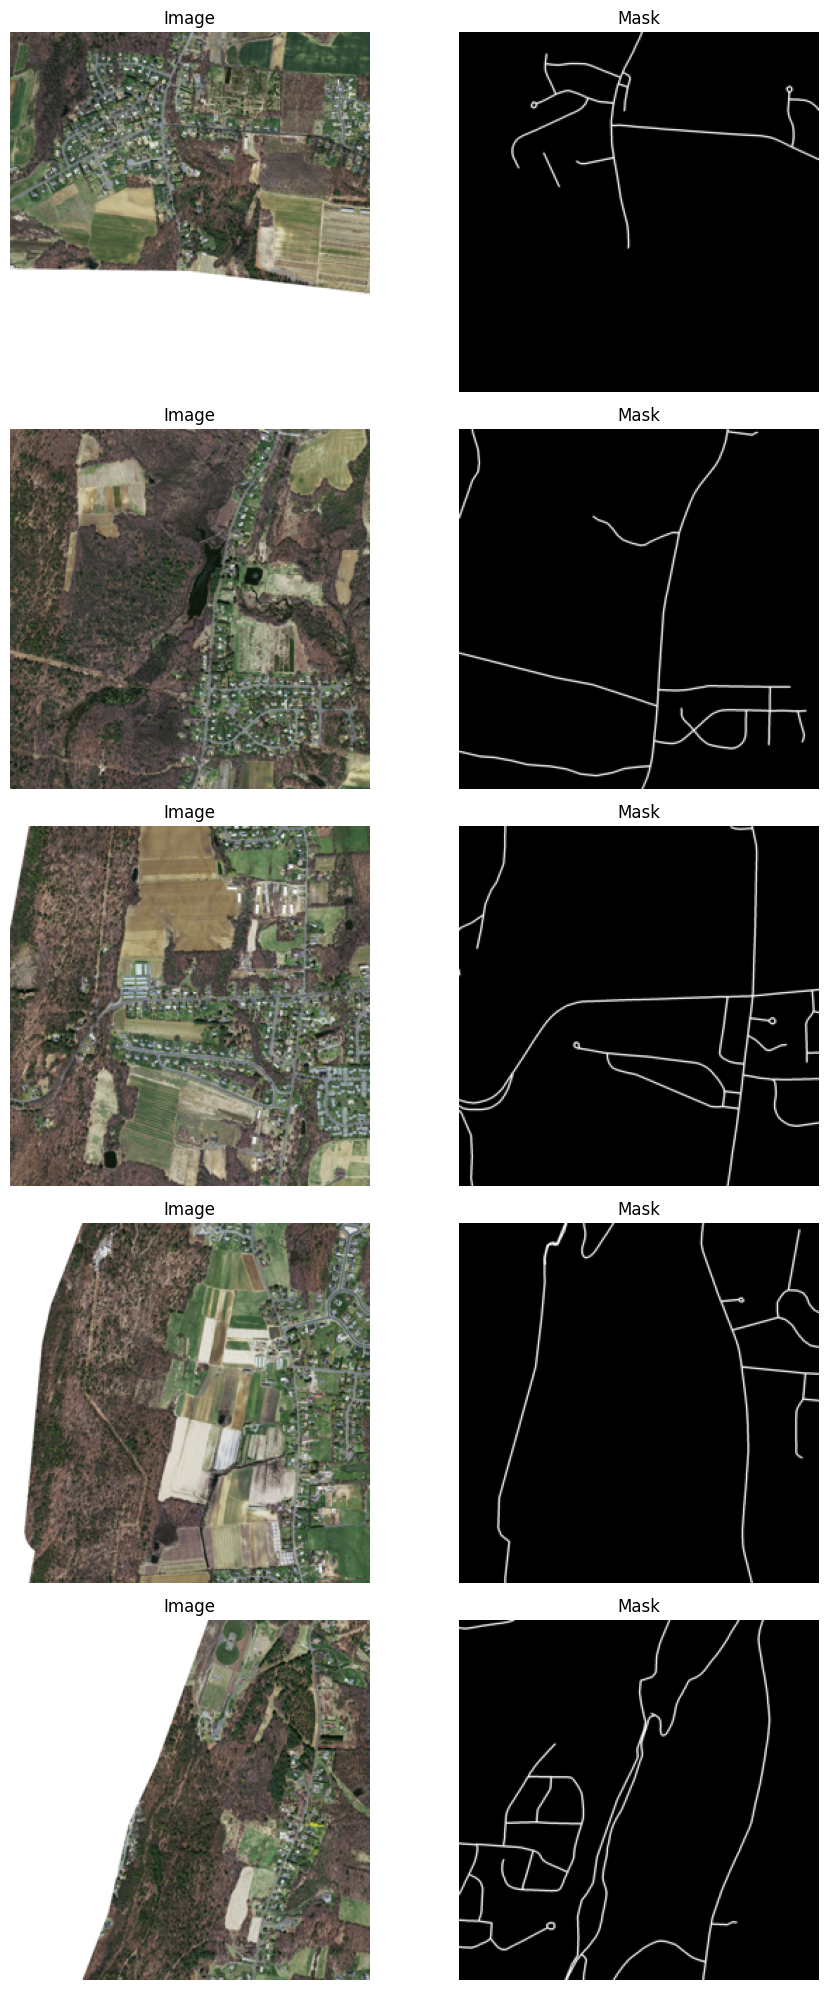

In [57]:
def visualize_images_and_masks(images, masks, n=5):
    plt.figure(figsize=(10, 4 * n))

    for i in range(n):
        plt.subplot(n, 2, 2 * i + 1)
        plt.imshow(images[i])
        plt.title("Image")
        plt.axis('off')

        plt.subplot(n, 2, 2 * i + 2)
        plt.imshow(masks[i], cmap='gray')
        plt.title("Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example visualization
visualize_images_and_masks(train_images, train_masks)

### Dataset Creation

Finally, we will make the dataset using the list of images we have stored.

In [58]:

class RoadDataset(Dataset):
    def __init__(self, images, masks, image_transform=None, mask_transform=None):
        self.images = images
        self.masks = masks
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
        mask = Image.fromarray(self.masks[idx])

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t > 0.5).float())
])

train_dataset = RoadDataset(train_images, train_masks, image_transform, mask_transform)
val_dataset   = RoadDataset(val_images, val_masks, image_transform, mask_transform)

train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader    = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,num_workers=NUM_WORKERS)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# UNet

Before proceeding, it is necessary to understand the idea behind UNet. In order to avoid too much details in this notebook, you can read the complete paper for UNet from [this link](https://arxiv.org/pdf/1505.04597).

The overall structure of UNet is provided in the image below.

![UNet Architecture](https://viso.ai/wp-content/uploads/2024/04/unet-process.png)

### Convolution Block

Convolution block is used at each level of UNet.

In [59]:
class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

### Up Convoluitional Block

We use another block to upsample the latent vector.

In [60]:
class UpConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.upconv = nn.Sequential(
            nn.ConvTranspose2d(in_channel, out_channel, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.upconv(x)

### Complete UNet Structure

Now using the ```ConvBlock``` and ```UpConvBlock``` you created, complete the UNet architecture.

In [61]:
class UNet(nn.Module):
    def __init__(self, in_channel=3, out_channel=1, filters=[64, 128, 256, 512]):
        super().__init__()

        # Encoder
        self.encoder1 = ConvBlock(in_channel, filters[0])
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = ConvBlock(filters[0], filters[1])
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = ConvBlock(filters[1], filters[2])
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = ConvBlock(filters[2], filters[3])
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = ConvBlock(filters[3], filters[3])  # First convolution in bottleneck

        # Decoder
        self.upconv4 = UpConvBlock(filters[3], filters[3])
        self.decoder4 = ConvBlock(filters[3] * 2, filters[3])
        self.upconv3 = UpConvBlock(filters[3], filters[2])
        self.decoder3 = ConvBlock(filters[2] * 2, filters[2])
        self.upconv2 = UpConvBlock(filters[2], filters[1])
        self.decoder2 = ConvBlock(filters[1] * 2, filters[1])
        self.upconv1 = UpConvBlock(filters[1], filters[0])
        self.decoder1 = ConvBlock(filters[0] * 2, filters[0])

        # Final layer
        self.final = nn.Conv2d(filters[0], out_channel, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool4(enc4))

        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = self.decoder4(torch.cat([dec4, enc4], dim=1))

        dec3 = self.upconv3(dec4)
        dec3 = self.decoder3(torch.cat([dec3, enc3], dim=1))

        dec2 = self.upconv2(dec3)
        dec2 = self.decoder2(torch.cat([dec2, enc2], dim=1))

        dec1 = self.upconv1(dec2)
        dec1 = self.decoder1(torch.cat([dec1, enc1], dim=1))

        return torch.sigmoid(self.final(dec1))

# Attention UNet

### Attention Mechanism

Attention UNet uses this mechanism to know what part the image is more important to attend to. You can read about this mechanism from [this link](https://arxiv.org/pdf/1706.03762). The Attention mechanism in UNet is described in [this paper](https://arxiv.org/pdf/1804.03999).


![Attention](https://www.researchgate.net/publication/373655981/figure/fig3/AS:11431281186315360@1693879045519/Visualization-of-attention-blocks-reveals-their-functionality-While-the-self-attention.png)

In [62]:
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        # g: from decoder
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int),
            nn.ReLU(inplace=True)
        )

        # x: from encoder
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int),
            nn.ReLU(inplace=True)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


Now use the ```AttentionBlock``` to inherit [Attention UNet](https://arxiv.org/pdf/1804.03999) from UNet.

![Attention UNet](https://www.researchgate.net/publication/347344899/figure/fig6/AS:971357475069952@1608601077414/The-architecture-of-Attention-U-Net-Attention-gate-selects-features-by-using-the.png)

In [63]:
class AttentionUNet(nn.Module):
    def __init__(self, in_channel=3, out_channel=1, filters=[64, 128, 256, 512]):
        super().__init__()

        # Encoder
        self.encoder1 = ConvBlock(in_channel, filters[0])
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = ConvBlock(filters[0], filters[1])
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = ConvBlock(filters[1], filters[2])
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = ConvBlock(filters[2], filters[3])
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = ConvBlock(filters[3], filters[3])

        # Decoder + Attention
        self.upconv4 = UpConvBlock(filters[3], filters[3])
        self.att4 = AttentionBlock(F_g=filters[3], F_l=filters[3], F_int=filters[3] // 2)
        self.decoder4 = ConvBlock(filters[3] * 2, filters[3])

        self.upconv3 = UpConvBlock(filters[3], filters[2])
        self.att3 = AttentionBlock(F_g=filters[2], F_l=filters[2], F_int=filters[2] // 2)
        self.decoder3 = ConvBlock(filters[2] * 2, filters[2])

        self.upconv2 = UpConvBlock(filters[2], filters[1])
        self.att2 = AttentionBlock(F_g=filters[1], F_l=filters[1], F_int=filters[1] // 2)
        self.decoder2 = ConvBlock(filters[1] * 2, filters[1])

        self.upconv1 = UpConvBlock(filters[1], filters[0])
        self.att1 = AttentionBlock(F_g=filters[0], F_l=filters[0], F_int=filters[0] // 2)
        self.decoder1 = ConvBlock(filters[0] * 2, filters[0])

        # Final output
        self.final = nn.Conv2d(filters[0], out_channel, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))


        bottleneck = self.bottleneck(self.pool4(enc4))

        # Decoder with Attention
        dec4 = self.upconv4(bottleneck)  # 16x16 → 32x32
        att4 = self.att4(dec4, enc4)
        dec4 = self.decoder4(torch.cat([dec4, att4], dim=1))  # 32x32

        dec3 = self.upconv3(dec4)  # 32x32 → 64x64
        att3 = self.att3(dec3, enc3)
        dec3 = self.decoder3(torch.cat([dec3, att3], dim=1))

        dec2 = self.upconv2(dec3)
        att2 = self.att2(dec2, enc2)
        dec2 = self.decoder2(torch.cat([dec2, att2], dim=1))

        dec1 = self.upconv1(dec2)
        att1 = self.att1(dec1, enc1)
        dec1 = self.decoder1(torch.cat([dec1, att1], dim=1))

        return torch.sigmoid(self.final(dec1))


# Residual Attention UNet

We will add residual blocks to the attention for better gradient flow. You can read more about residual blocks [here](https://arxiv.org/pdf/1512.03385).

<img src="https://dfzljdn9uc3pi.cloudfront.net/2023/cs-1302/1/fig-1-full.png" width="400" alt="ResUNet Architecture">

In [64]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel, stride=1):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channel)
        )

        self.shortcut = nn.Sequential()
        if in_channel != out_channel or stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channel)
            )

    def forward(self, x):
        out = self.conv_block(x)
        out += self.shortcut(x)  # skip connection
        return F.relu(out, inplace=True)


Use ```ResidualConvBlock``` to construct Residual Attention Unet.

In [65]:
class ResidualAttentionUNet(AttentionUNet):
    def __init__(self, in_channel=3, out_channel=1, filter_sizes=[64, 128, 256, 512]):
        super().__init__(in_channel, out_channel, filter_sizes)

        self.encoder1 = ResidualConvBlock(in_channel, filter_sizes[0])
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = ResidualConvBlock(filter_sizes[0], filter_sizes[1])
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = ResidualConvBlock(filter_sizes[1], filter_sizes[2])
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = ResidualConvBlock(filter_sizes[2], filter_sizes[3])
        self.pool4 = nn.MaxPool2d(2)  # 16x16
        self.bottleneck = ResidualConvBlock(filter_sizes[3], filter_sizes[3])

        self.upconv4 = UpConvBlock(filter_sizes[3], filter_sizes[3])
        self.att4 = AttentionBlock(F_g=filter_sizes[3], F_l=filter_sizes[3], F_int=filter_sizes[3] // 2)
        self.decoder4 = ResidualConvBlock(filter_sizes[3] * 2, filter_sizes[3])
        self.up3 = UpConvBlock(filter_sizes[3], filter_sizes[2])
        self.att3 = AttentionBlock(F_g=filter_sizes[2], F_l=filter_sizes[2], F_int=filter_sizes[2]//2)
        self.decoder3 = ResidualConvBlock(filter_sizes[2]*2, filter_sizes[2])

        self.up2 = UpConvBlock(filter_sizes[2], filter_sizes[1])
        self.att2 = AttentionBlock(F_g=filter_sizes[1], F_l=filter_sizes[1], F_int=filter_sizes[1]//2)
        self.decoder2 = ResidualConvBlock(filter_sizes[1]*2, filter_sizes[1])

        self.up1 = UpConvBlock(filter_sizes[1], filter_sizes[0])
        self.att1 = AttentionBlock(F_g=filter_sizes[0], F_l=filter_sizes[0], F_int=filter_sizes[0]//2)
        self.decoder1 = ResidualConvBlock(filter_sizes[0]*2, filter_sizes[0])

        self.final = nn.Conv2d(filter_sizes[0], out_channel, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        att4 = self.att4(dec4, enc4)
        dec4 = self.decoder4(torch.cat([dec4, att4], dim=1))

        dec3 = self.upconv3(dec4)
        att3 = self.att3(dec3, enc3)
        dec3 = self.decoder3(torch.cat([dec3, att3], dim=1))

        dec2 = self.upconv2(dec3)
        att2 = self.att2(dec2, enc2)
        dec2 = self.decoder2(torch.cat([dec2, att2], dim=1))

        dec1 = self.upconv1(dec2)
        att1 = self.att1(dec1, enc1)
        dec1 = self.decoder1(torch.cat([dec1, att1], dim=1))

        return torch.sigmoid(self.final(dec1))

# Training

Now it is time to train the model on training data.

### Loss Function

We will be using the sum of [Dice Score](https://oecd.ai/en/catalogue/metrics/dice-score#:~:text=The%20Dice%20score%20is%20calculated,sizes%20of%20the%20two%20sets.), [Iou Score](https://www.v7labs.com/blog/intersection-over-union-guide), and Binary Cross Entropy as loss function. You can read about the mentioned scores in the provided links.

<font color=cyan><b> Note: Do Not Change The ```OverallLoss``` Function as it is used for measuring you model's performance.</b></font>

In [66]:
### DICE LOSS

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, real):
        pred = pred.view(-1)
        real = real.view(-1)
        intersection = (pred * real).sum()
        dice_coeff = (2. * intersection + self.smooth) / (pred.sum() + real.sum() + self.smooth)
        return 1 - dice_coeff


### Iou Loss
class IouLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(IouLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, real):
        pred = pred.view(-1)
        real = real.view(-1)
        intersection = (pred * real).sum()
        total = (pred + real).sum()
        union = total - intersection
        iou_coeff = (intersection + self.smooth) / (union + self.smooth)
        return 1 - iou_coeff


### Overall Loss (DO NOT CHANGE)
class OverallLoss(nn.Module):
    """
    Combined loss function that sums Dice loss, IoU loss, and Binary Cross-Entropy loss.

    Args:
        smooth (float): Small constant to avoid division by zero.
    """
    def __init__(self, smooth=1e-6):
        super(OverallLoss, self).__init__()
        self.dice_loss = DiceLoss(smooth)
        self.iou_loss = IouLoss(smooth)
        self.bce_loss = nn.BCELoss()

    def forward(self, pred, real):
        dice = self.dice_loss(pred, real)
        iou = self.iou_loss(pred, real)
        bce = self.bce_loss(pred, real)

        return dice, iou, bce, dice+iou+bce

### Training Epoch

Complete the function below to train the model for one epoch.

In [67]:

def train_one_epoch(model, optimizer, criterion, data_loader, scheduler=None, device='cuda'):
    total_loss = 0.0
    model.train()
    for i, (img, mask) in enumerate(tqdm(data_loader)):
        img = img.to(device)
        mask = mask.to(device)

        optimizer.zero_grad()
        pred = model(img)
        _, _, _, loss = criterion(pred, mask)
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)


Design a function for evaluation after each training phase.

In [68]:
def evaluate_model(model, criterion, data_loader, device='cuda', threshold=0.5):
    """
    Evaluates the model on validation or test data.

    Args:
        model (nn.Module): The neural network model to evaluate.
        criterion (nn.Module): Loss function to compute evaluation metrics.
        data_loader (DataLoader): DataLoader providing evaluation batches.
        device (str): Device to run evaluation on ('cuda' or 'cpu').
        threshold (float): Threshold to binarize predictions for IoU and Dice.

    Returns:
        tuple: Average loss, average IoU score, and average Dice score over the dataset.
    """
    total_loss = 0.0
    iou_score = 0.0
    dice_score = 0.0
    model.eval()

    with torch.no_grad():
        for i, (img, mask) in enumerate(tqdm(data_loader)):
            # Move the image and mask to device
            img = img.to(device)
            mask = mask.to(device)

            # Predict the mask
            pred = model(img)

            # Compute the loss
            dice_loss, iou_loss, bce_loss, overall_loss = criterion(pred, mask)
            total_loss += overall_loss.item()

            # Binarize predictions for metric computation
            pred_bin = (pred > threshold).float()
            dice_score += 1 - DiceLoss()(pred_bin, mask).item()
            iou_score += 1 - IouLoss()(pred_bin, mask).item()

        total_loss /= len(data_loader)
        iou_score /= len(data_loader)
        dice_score /= len(data_loader)

    return total_loss, iou_score, dice_score


# Model Training

### UNet  
Create an instance of UNet and train it. Then report the results.  

<b><font color=red>Note: your models need to satisfy below conditions to get complete score.</font></b>

<table style="width: 100%; font-size: 18px; border-collapse: collapse; margin: 15px 0;">
  <tr>
    <th style="text-align: left; padding: 8px; border-bottom: 2px solid #ddd;">Model</th>
    <th style="text-align: right; padding: 8px; border-bottom: 2px solid #ddd;">Validation Loss</th>
    <th style="text-align: right; padding: 8px; border-bottom: 2px solid #ddd;">Iou Score</th>
    <th style="text-align: right; padding: 8px; border-bottom: 2px solid #ddd;">Dice Score</th>
  </tr>
  <tr>
    <td style="padding: 8px; border-bottom: 1px solid #ddd;">UNet</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&lt; 1.0</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.5</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.6</td>
  </tr>
  <tr>
    <td style="padding: 8px; border-bottom: 1px solid #ddd;">Attention UNet</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&lt; 0.9</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.6</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.65</td>
  </tr>
  <tr>
    <td style="padding: 8px;">Residual Attention UNet</td>
    <td style="text-align: right; padding: 8px;">&lt; 0.8</td>
    <td style="text-align: right; padding: 8px;">&gt; 0.65</td>
    <td style="text-align: right; padding: 8px;">&gt; 0.7</td>
  </tr>
</table>

In [69]:
NUM_EPOCHS = 15
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

unet = UNet().to(device)
criterion = OverallLoss()
# You can use other optimizers or Adam optimizer with customized weight decay, b1, or b2
optimizer = Adam(unet.parameters(), lr=LR)
# Add a scheduler if you like

best_loss = 100.0
for i in range(NUM_EPOCHS):
    train_loss = train_one_epoch(unet, optimizer, criterion, train_loader, device=device)
    val_loss, iou_score, dice_score = evaluate_model(unet, criterion, val_loader, device=device)


    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(unet.state_dict(), "best_unet.pth")

    print(f"Iteration {i+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.2f} | "
          f"Val Loss: {val_loss:.2f} | "
          f"Iou Score: {iou_score:.2f} | "
          f"Dice Score: {dice_score:.2f}")



100%|██████████| 4/4 [00:00<00:00,  6.69it/s]


Iteration 1/15: Train Loss: 1.51 | Val Loss: 1.14 | Iou Score: 0.47 | Dice Score: 0.64


100%|██████████| 4/4 [00:00<00:00,  7.65it/s]


Iteration 2/15: Train Loss: 1.15 | Val Loss: 1.14 | Iou Score: 0.48 | Dice Score: 0.65


100%|██████████| 4/4 [00:00<00:00,  8.35it/s]


Iteration 3/15: Train Loss: 1.10 | Val Loss: 1.03 | Iou Score: 0.51 | Dice Score: 0.68


100%|██████████| 4/4 [00:00<00:00,  8.46it/s]


Iteration 4/15: Train Loss: 1.07 | Val Loss: 0.98 | Iou Score: 0.53 | Dice Score: 0.70


100%|██████████| 4/4 [00:00<00:00,  8.37it/s]


Iteration 5/15: Train Loss: 1.05 | Val Loss: 0.95 | Iou Score: 0.54 | Dice Score: 0.70


100%|██████████| 4/4 [00:00<00:00,  8.59it/s]


Iteration 6/15: Train Loss: 1.03 | Val Loss: 0.91 | Iou Score: 0.56 | Dice Score: 0.72


100%|██████████| 4/4 [00:00<00:00,  8.11it/s]


Iteration 7/15: Train Loss: 1.01 | Val Loss: 0.95 | Iou Score: 0.55 | Dice Score: 0.71


100%|██████████| 4/4 [00:00<00:00,  8.15it/s]


Iteration 8/15: Train Loss: 0.99 | Val Loss: 0.89 | Iou Score: 0.57 | Dice Score: 0.73


100%|██████████| 4/4 [00:00<00:00,  8.34it/s]


Iteration 9/15: Train Loss: 0.99 | Val Loss: 0.92 | Iou Score: 0.56 | Dice Score: 0.72


100%|██████████| 4/4 [00:00<00:00,  8.40it/s]


Iteration 10/15: Train Loss: 0.98 | Val Loss: 0.89 | Iou Score: 0.57 | Dice Score: 0.73


100%|██████████| 4/4 [00:00<00:00,  7.96it/s]


Iteration 11/15: Train Loss: 0.97 | Val Loss: 0.91 | Iou Score: 0.56 | Dice Score: 0.72


100%|██████████| 4/4 [00:00<00:00,  7.92it/s]


Iteration 12/15: Train Loss: 0.96 | Val Loss: 0.87 | Iou Score: 0.58 | Dice Score: 0.73


100%|██████████| 4/4 [00:00<00:00,  8.31it/s]


Iteration 13/15: Train Loss: 0.95 | Val Loss: 0.85 | Iou Score: 0.59 | Dice Score: 0.74


100%|██████████| 4/4 [00:00<00:00,  6.32it/s]


Iteration 14/15: Train Loss: 0.95 | Val Loss: 0.90 | Iou Score: 0.57 | Dice Score: 0.72


100%|██████████| 4/4 [00:00<00:00,  6.41it/s]

Iteration 15/15: Train Loss: 0.94 | Val Loss: 0.86 | Iou Score: 0.58 | Dice Score: 0.74


Now do the same for Attention UNet and Reidual Attention UNet.

In [70]:
NUM_EPOCHS = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

attention_unet = AttentionUNet().to(device)
criterion = OverallLoss()
# You can use other optimizers or Adam optimizer with customized weight decay, b1, or b2
optimizer = Adam(attention_unet.parameters(), lr=LR)

best_loss = 100.0
for i in range(NUM_EPOCHS):
    train_loss = train_one_epoch(attention_unet, optimizer, criterion, train_loader , device=device)
    val_loss, iou_score, dice_score = evaluate_model(attention_unet, criterion, val_loader , device=device)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(attention_unet.state_dict(), "best_attention_unet.pth")

    print(f"Iteration {i+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.2f} | "
          f"Val Loss: {val_loss:.2f} | "
          f"Iou Score: {iou_score:.2f} | "
          f"Dice Score: {dice_score:.2f}")

100%|██████████| 4/4 [00:00<00:00,  7.42it/s]


Iteration 1/30: Train Loss: 1.59 | Val Loss: 1.18 | Iou Score: 0.44 | Dice Score: 0.61


100%|██████████| 4/4 [00:00<00:00,  7.82it/s]


Iteration 2/30: Train Loss: 1.16 | Val Loss: 1.07 | Iou Score: 0.49 | Dice Score: 0.66


100%|██████████| 4/4 [00:00<00:00,  7.02it/s]


Iteration 3/30: Train Loss: 1.10 | Val Loss: 1.07 | Iou Score: 0.50 | Dice Score: 0.66


100%|██████████| 4/4 [00:00<00:00,  7.85it/s]


Iteration 4/30: Train Loss: 1.07 | Val Loss: 1.00 | Iou Score: 0.52 | Dice Score: 0.68


100%|██████████| 4/4 [00:00<00:00,  7.68it/s]


Iteration 5/30: Train Loss: 1.04 | Val Loss: 0.94 | Iou Score: 0.55 | Dice Score: 0.71


100%|██████████| 4/4 [00:00<00:00,  7.12it/s]


Iteration 6/30: Train Loss: 1.02 | Val Loss: 0.91 | Iou Score: 0.56 | Dice Score: 0.72


100%|██████████| 4/4 [00:00<00:00,  6.34it/s]


Iteration 7/30: Train Loss: 1.02 | Val Loss: 0.91 | Iou Score: 0.56 | Dice Score: 0.72


100%|██████████| 4/4 [00:00<00:00,  7.76it/s]


Iteration 8/30: Train Loss: 1.00 | Val Loss: 0.91 | Iou Score: 0.56 | Dice Score: 0.72


100%|██████████| 4/4 [00:00<00:00,  7.34it/s]


Iteration 9/30: Train Loss: 1.00 | Val Loss: 0.90 | Iou Score: 0.57 | Dice Score: 0.72


100%|██████████| 4/4 [00:00<00:00,  6.98it/s]


Iteration 10/30: Train Loss: 0.98 | Val Loss: 0.88 | Iou Score: 0.57 | Dice Score: 0.73


100%|██████████| 4/4 [00:00<00:00,  7.94it/s]


Iteration 11/30: Train Loss: 0.97 | Val Loss: 0.89 | Iou Score: 0.57 | Dice Score: 0.73


100%|██████████| 4/4 [00:00<00:00,  7.59it/s]


Iteration 12/30: Train Loss: 0.96 | Val Loss: 0.90 | Iou Score: 0.57 | Dice Score: 0.73


100%|██████████| 4/4 [00:00<00:00,  6.00it/s]


Iteration 13/30: Train Loss: 0.96 | Val Loss: 0.91 | Iou Score: 0.56 | Dice Score: 0.72


100%|██████████| 4/4 [00:00<00:00,  7.59it/s]


Iteration 14/30: Train Loss: 0.96 | Val Loss: 0.89 | Iou Score: 0.57 | Dice Score: 0.73


100%|██████████| 4/4 [00:00<00:00,  7.75it/s]


Iteration 15/30: Train Loss: 0.94 | Val Loss: 0.89 | Iou Score: 0.57 | Dice Score: 0.73


100%|██████████| 4/4 [00:00<00:00,  8.00it/s]


Iteration 16/30: Train Loss: 0.94 | Val Loss: 0.86 | Iou Score: 0.58 | Dice Score: 0.74


100%|██████████| 4/4 [00:00<00:00,  7.72it/s]


Iteration 17/30: Train Loss: 0.93 | Val Loss: 0.85 | Iou Score: 0.59 | Dice Score: 0.74


100%|██████████| 4/4 [00:00<00:00,  7.97it/s]


Iteration 18/30: Train Loss: 0.93 | Val Loss: 0.85 | Iou Score: 0.59 | Dice Score: 0.74


100%|██████████| 4/4 [00:00<00:00,  6.04it/s]


Iteration 19/30: Train Loss: 0.92 | Val Loss: 0.86 | Iou Score: 0.58 | Dice Score: 0.74


100%|██████████| 4/4 [00:00<00:00,  7.54it/s]


Iteration 20/30: Train Loss: 0.91 | Val Loss: 0.84 | Iou Score: 0.59 | Dice Score: 0.74


100%|██████████| 4/4 [00:00<00:00,  7.84it/s]


Iteration 21/30: Train Loss: 0.91 | Val Loss: 0.87 | Iou Score: 0.58 | Dice Score: 0.73


100%|██████████| 4/4 [00:00<00:00,  7.68it/s]


Iteration 22/30: Train Loss: 0.90 | Val Loss: 0.84 | Iou Score: 0.59 | Dice Score: 0.74


100%|██████████| 4/4 [00:00<00:00,  7.42it/s]


Iteration 23/30: Train Loss: 0.90 | Val Loss: 0.86 | Iou Score: 0.59 | Dice Score: 0.74


100%|██████████| 4/4 [00:00<00:00,  7.85it/s]


Iteration 24/30: Train Loss: 0.89 | Val Loss: 0.86 | Iou Score: 0.59 | Dice Score: 0.74


100%|██████████| 4/4 [00:00<00:00,  5.73it/s]


Iteration 25/30: Train Loss: 0.89 | Val Loss: 0.87 | Iou Score: 0.58 | Dice Score: 0.74


100%|██████████| 4/4 [00:00<00:00,  7.81it/s]


Iteration 26/30: Train Loss: 0.89 | Val Loss: 0.88 | Iou Score: 0.57 | Dice Score: 0.73


100%|██████████| 4/4 [00:00<00:00,  7.22it/s]


Iteration 27/30: Train Loss: 0.87 | Val Loss: 0.84 | Iou Score: 0.59 | Dice Score: 0.74


100%|██████████| 4/4 [00:00<00:00,  7.85it/s]


Iteration 28/30: Train Loss: 0.87 | Val Loss: 0.85 | Iou Score: 0.59 | Dice Score: 0.74


100%|██████████| 4/4 [00:00<00:00,  7.38it/s]


Iteration 29/30: Train Loss: 0.86 | Val Loss: 0.84 | Iou Score: 0.59 | Dice Score: 0.74


100%|██████████| 4/4 [00:00<00:00,  5.98it/s]

Iteration 30/30: Train Loss: 0.85 | Val Loss: 0.85 | Iou Score: 0.59 | Dice Score: 0.74


For Residual Attention UNet, plot the changes in train and validation loss.

In [71]:
NUM_EPOCHS = 40
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

resattn_unet = ResidualAttentionUNet().to(device)
criterion = OverallLoss()
# You can use other optimizers or Adam optimizer with customized weight decay, b1, or b2
optimizer = Adam(resattn_unet.parameters(), lr=LR)

train_losses = []
val_losses = []

best_loss = 100.0
for i in range(NUM_EPOCHS):
    train_loss = train_one_epoch(resattn_unet, optimizer, criterion, train_loader , device=device)
    val_loss, iou_score, dice_score = evaluate_model(resattn_unet, criterion, val_loader , device=device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_loss:
        torch.save(resattn_unet.state_dict(), "best_residual_attention_unet.pth")

    print(f"Iteration {i+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.2f} | "
          f"Val Loss: {val_loss:.2f} | "
          f"Iou Score: {iou_score:.2f} | "
          f"Dice Score: {dice_score:.2f}")

100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


Iteration 1/40: Train Loss: 1.47 | Val Loss: 1.13 | Iou Score: 0.46 | Dice Score: 0.63


100%|██████████| 4/4 [00:00<00:00,  6.01it/s]


Iteration 2/40: Train Loss: 1.14 | Val Loss: 0.97 | Iou Score: 0.53 | Dice Score: 0.69


100%|██████████| 4/4 [00:00<00:00,  5.77it/s]


Iteration 3/40: Train Loss: 1.07 | Val Loss: 0.95 | Iou Score: 0.54 | Dice Score: 0.70


100%|██████████| 4/4 [00:00<00:00,  5.98it/s]


Iteration 4/40: Train Loss: 1.04 | Val Loss: 0.91 | Iou Score: 0.56 | Dice Score: 0.72


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


Iteration 5/40: Train Loss: 1.01 | Val Loss: 0.92 | Iou Score: 0.56 | Dice Score: 0.71


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


Iteration 6/40: Train Loss: 1.00 | Val Loss: 0.93 | Iou Score: 0.55 | Dice Score: 0.71


100%|██████████| 4/4 [00:00<00:00,  5.77it/s]


Iteration 7/40: Train Loss: 0.98 | Val Loss: 0.88 | Iou Score: 0.57 | Dice Score: 0.73


100%|██████████| 4/4 [00:00<00:00,  5.76it/s]


Iteration 8/40: Train Loss: 0.99 | Val Loss: 0.87 | Iou Score: 0.58 | Dice Score: 0.73


100%|██████████| 4/4 [00:00<00:00,  5.91it/s]


Iteration 9/40: Train Loss: 0.96 | Val Loss: 0.85 | Iou Score: 0.59 | Dice Score: 0.74


100%|██████████| 4/4 [00:00<00:00,  5.78it/s]


Iteration 10/40: Train Loss: 0.96 | Val Loss: 0.85 | Iou Score: 0.59 | Dice Score: 0.74


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


Iteration 11/40: Train Loss: 0.95 | Val Loss: 0.87 | Iou Score: 0.58 | Dice Score: 0.73


100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Iteration 12/40: Train Loss: 0.94 | Val Loss: 0.84 | Iou Score: 0.59 | Dice Score: 0.74


100%|██████████| 4/4 [00:00<00:00,  5.70it/s]


Iteration 13/40: Train Loss: 0.93 | Val Loss: 0.83 | Iou Score: 0.60 | Dice Score: 0.75


100%|██████████| 4/4 [00:00<00:00,  5.90it/s]


Iteration 14/40: Train Loss: 0.92 | Val Loss: 0.86 | Iou Score: 0.58 | Dice Score: 0.74


100%|██████████| 4/4 [00:00<00:00,  5.61it/s]


Iteration 15/40: Train Loss: 0.92 | Val Loss: 0.83 | Iou Score: 0.60 | Dice Score: 0.75


100%|██████████| 4/4 [00:00<00:00,  5.22it/s]


Iteration 16/40: Train Loss: 0.91 | Val Loss: 0.83 | Iou Score: 0.60 | Dice Score: 0.75


100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Iteration 17/40: Train Loss: 0.91 | Val Loss: 0.82 | Iou Score: 0.60 | Dice Score: 0.75


100%|██████████| 4/4 [00:00<00:00,  5.65it/s]


Iteration 18/40: Train Loss: 0.90 | Val Loss: 0.85 | Iou Score: 0.59 | Dice Score: 0.74


100%|██████████| 4/4 [00:00<00:00,  5.73it/s]


Iteration 19/40: Train Loss: 0.90 | Val Loss: 0.83 | Iou Score: 0.60 | Dice Score: 0.75


100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


Iteration 20/40: Train Loss: 0.89 | Val Loss: 0.82 | Iou Score: 0.60 | Dice Score: 0.75


100%|██████████| 4/4 [00:00<00:00,  5.67it/s]


Iteration 21/40: Train Loss: 0.88 | Val Loss: 0.82 | Iou Score: 0.60 | Dice Score: 0.75


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


Iteration 22/40: Train Loss: 0.87 | Val Loss: 0.81 | Iou Score: 0.61 | Dice Score: 0.75


100%|██████████| 4/4 [00:00<00:00,  5.20it/s]


Iteration 23/40: Train Loss: 0.87 | Val Loss: 0.82 | Iou Score: 0.61 | Dice Score: 0.75


100%|██████████| 4/4 [00:00<00:00,  5.74it/s]


Iteration 24/40: Train Loss: 0.86 | Val Loss: 0.83 | Iou Score: 0.60 | Dice Score: 0.75


100%|██████████| 4/4 [00:00<00:00,  5.85it/s]


Iteration 25/40: Train Loss: 0.86 | Val Loss: 0.83 | Iou Score: 0.60 | Dice Score: 0.75


100%|██████████| 4/4 [00:00<00:00,  5.82it/s]


Iteration 26/40: Train Loss: 0.85 | Val Loss: 0.82 | Iou Score: 0.60 | Dice Score: 0.75


100%|██████████| 4/4 [00:00<00:00,  5.74it/s]


Iteration 27/40: Train Loss: 0.85 | Val Loss: 0.85 | Iou Score: 0.59 | Dice Score: 0.74


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


Iteration 28/40: Train Loss: 0.85 | Val Loss: 0.80 | Iou Score: 0.61 | Dice Score: 0.76


100%|██████████| 4/4 [00:00<00:00,  4.90it/s]


Iteration 29/40: Train Loss: 0.84 | Val Loss: 0.83 | Iou Score: 0.60 | Dice Score: 0.75


100%|██████████| 4/4 [00:00<00:00,  5.92it/s]


Iteration 30/40: Train Loss: 0.83 | Val Loss: 0.81 | Iou Score: 0.60 | Dice Score: 0.75


100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Iteration 31/40: Train Loss: 0.83 | Val Loss: 0.80 | Iou Score: 0.61 | Dice Score: 0.76


100%|██████████| 4/4 [00:00<00:00,  5.77it/s]


Iteration 32/40: Train Loss: 0.82 | Val Loss: 0.80 | Iou Score: 0.61 | Dice Score: 0.76


100%|██████████| 4/4 [00:00<00:00,  5.94it/s]


Iteration 33/40: Train Loss: 0.81 | Val Loss: 0.82 | Iou Score: 0.61 | Dice Score: 0.75


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Iteration 34/40: Train Loss: 0.81 | Val Loss: 0.83 | Iou Score: 0.60 | Dice Score: 0.75


100%|██████████| 4/4 [00:00<00:00,  5.65it/s]


Iteration 35/40: Train Loss: 0.81 | Val Loss: 0.81 | Iou Score: 0.61 | Dice Score: 0.76


100%|██████████| 4/4 [00:00<00:00,  5.71it/s]


Iteration 36/40: Train Loss: 0.79 | Val Loss: 0.81 | Iou Score: 0.61 | Dice Score: 0.75


100%|██████████| 4/4 [00:00<00:00,  5.77it/s]


Iteration 37/40: Train Loss: 0.79 | Val Loss: 0.82 | Iou Score: 0.60 | Dice Score: 0.75


100%|██████████| 4/4 [00:00<00:00,  5.84it/s]


Iteration 38/40: Train Loss: 0.78 | Val Loss: 0.82 | Iou Score: 0.61 | Dice Score: 0.75


100%|██████████| 4/4 [00:00<00:00,  5.57it/s]


Iteration 39/40: Train Loss: 0.78 | Val Loss: 0.84 | Iou Score: 0.59 | Dice Score: 0.74


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


Iteration 40/40: Train Loss: 0.78 | Val Loss: 0.81 | Iou Score: 0.61 | Dice Score: 0.76


Now Visualize losses.

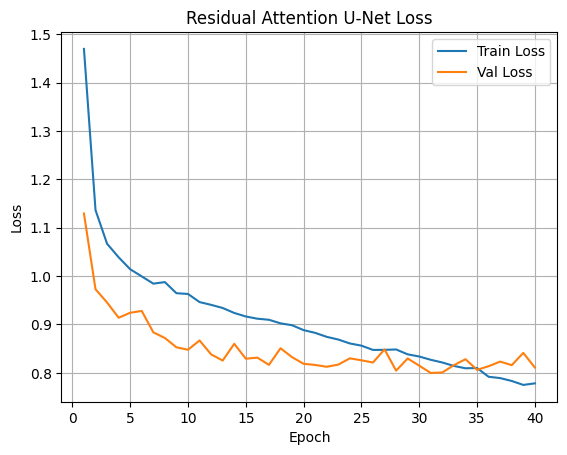

In [72]:
import matplotlib.pyplot as plt

# Assuming train_losses and val_losses are already populated from your training loop
epochs = range(1, len(train_losses) + 1)
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Residual Attention U-Net Loss')
plt.legend()
plt.grid(True)
plt.show()


### Prediction Visualisation

Display several images, their masks, and the predicted mask by your model.

In [73]:
def visualize_image_mask_prediction(images, masks, predictions, n=5):
    plt.figure(figsize=(12, 4 * n))

    for i in range(n):
        # Original Image
        plt.subplot(n, 3, 3*i + 1)
        plt.imshow(images[i])
        plt.title(f'Image {i+1}')
        plt.axis('off')

        # Ground Truth Mask
        plt.subplot(n, 3, 3*i + 2)
        plt.imshow(masks[i], cmap='gray')
        plt.title(f'Mask {i+1}')
        plt.axis('off')

        # Predicted Mask
        plt.subplot(n, 3, 3*i + 3)
        plt.imshow(predictions[i], cmap='gray')
        plt.title(f'Prediction {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

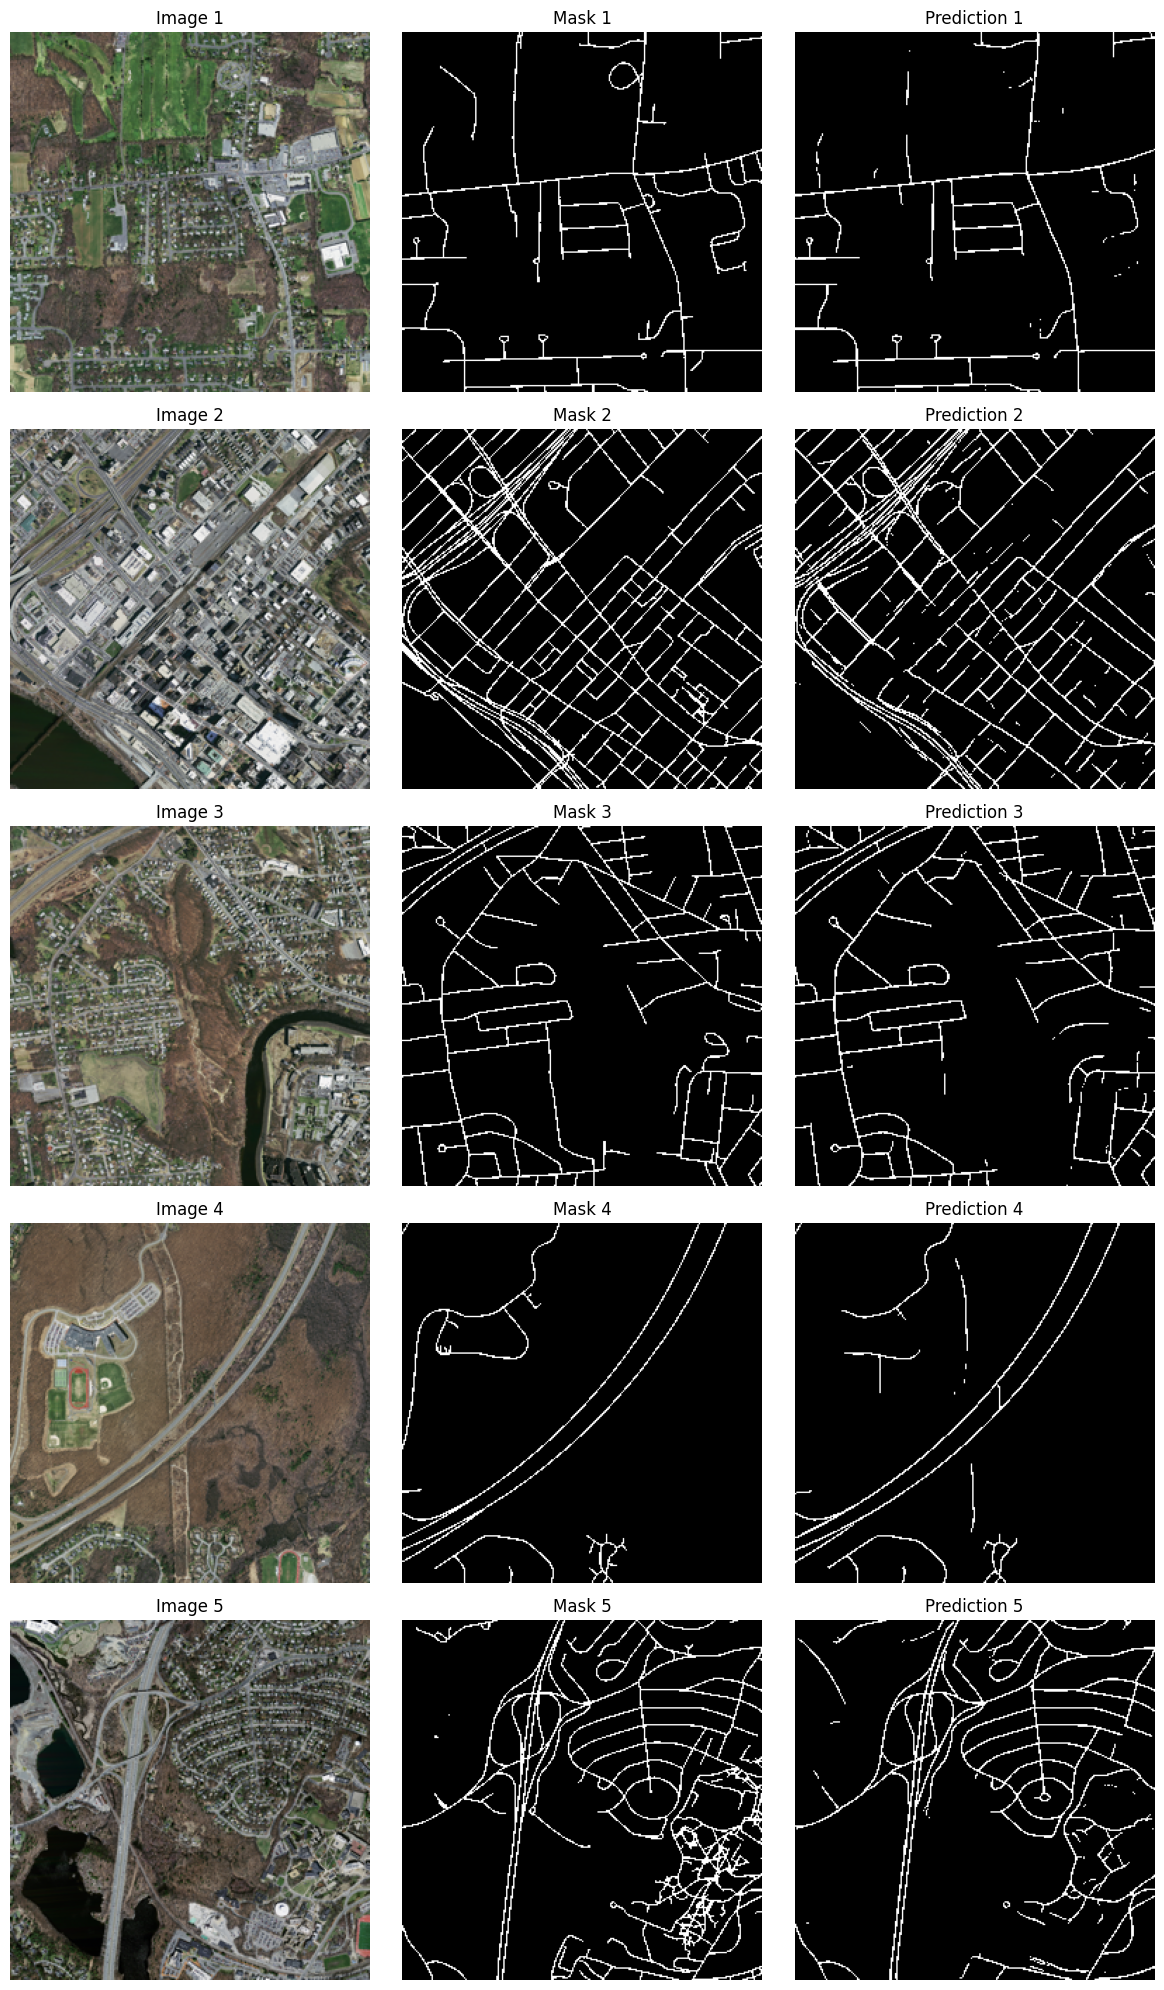

In [74]:

resattn_unet.load_state_dict(torch.load("best_residual_attention_unet.pth", map_location=device))
resattn_unet.eval()


images_np, masks_np, predictions_np = [], [], []
samples_needed = 5
samples_collected = 0

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)
        predictions = resattn_unet(images)

        batch_images_np = images.cpu().numpy() * np.array([0.5, 0.5, 0.5])[:, None, None] + np.array([0.5, 0.5, 0.5])[:, None, None]
        batch_images_np = np.transpose(batch_images_np, (0, 2, 3, 1))
        batch_masks_np = masks.cpu().numpy().squeeze(1)
        batch_predictions_np = (predictions > 0.5).float().cpu().numpy().squeeze(1)
        images_np.append(batch_images_np)
        masks_np.append(batch_masks_np)
        predictions_np.append(batch_predictions_np)
        samples_collected += len(batch_images_np)
        if samples_collected >= samples_needed:
            break


images_np = np.concatenate(images_np, axis=0)[:5]
masks_np = np.concatenate(masks_np, axis=0)[:5]
predictions_np = np.concatenate(predictions_np, axis=0)[:5]


visualize_image_mask_prediction(images_np, masks_np, predictions_np, n=5)